# Deep Unsupervised Image Segmentation


#### Load data and libraries

In [ ]:
!pip install basic-image-eda

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
from skimage.transform import rescale, resize
from skimage import io
from basic_image_eda import BasicImageEDA


In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
## Need to manually load kaggle.json file first
!cp /kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat '/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset
!ls
!unzip /content/semantic-drone-dataset.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
sample_data
unzip:  cannot find or open /content/semantic-drone-dataset.zip, /content/semantic-drone-dataset.zip.zip or /content/semantic-drone-dataset.zip.ZIP.


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: flatbuffers, six, h5py, gast, google-pasta, numpy, absl-py, keras-preprocessing, opt-einsum, typing-extensions, wheel, tensorboard, astunparse, tensorflow-estimator, grpcio, wrapt, protobuf, termcolor
Required-by: fancyimpute


### Pet Dataset

In [ ]:
(pet_train, pet_test), pet_info = tfds.load('oxford_iiit_pet:3.*.*', split=['train', 'test'], shuffle_files=True, with_info=True)
assert isinstance(pet_train, tf.data.Dataset)
assert isinstance(pet_test, tf.data.Dataset)

In [ ]:
pet_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [ ]:
iterator = pet_train.__iter__()
next_element = iterator.get_next()
print(next_element)

{'file_name': <tf.Tensor: shape=(), dtype=string, numpy=b'miniature_pinscher_102.jpg'>, 'image': <tf.Tensor: shape=(333, 500, 3), dtype=uint8, numpy=
array([[[ 83,  59,  25],
        [ 84,  59,  28],
        [ 83,  58,  28],
        ...,
        [117, 110, 100],
        [109, 102,  94],
        [119, 112, 104]],

       [[ 82,  57,  26],
        [ 84,  59,  29],
        [ 82,  57,  27],
        ...,
        [118, 111, 101],
        [111, 104,  96],
        [120, 113, 105]],

       [[ 83,  58,  28],
        [ 85,  59,  32],
        [ 83,  57,  30],
        ...,
        [118, 111, 101],
        [112, 105,  97],
        [119, 112, 104]],

       ...,

       [[194, 199, 195],
        [195, 197, 196],
        [194, 194, 194],
        ...,
        [157, 139, 115],
        [152, 134, 110],
        [143, 126, 108]],

       [[196, 200, 199],
        [194, 196, 195],
        [195, 195, 195],
        ...,
        [163, 143, 118],
        [158, 141, 115],
        [144, 126, 106]],

       [[197

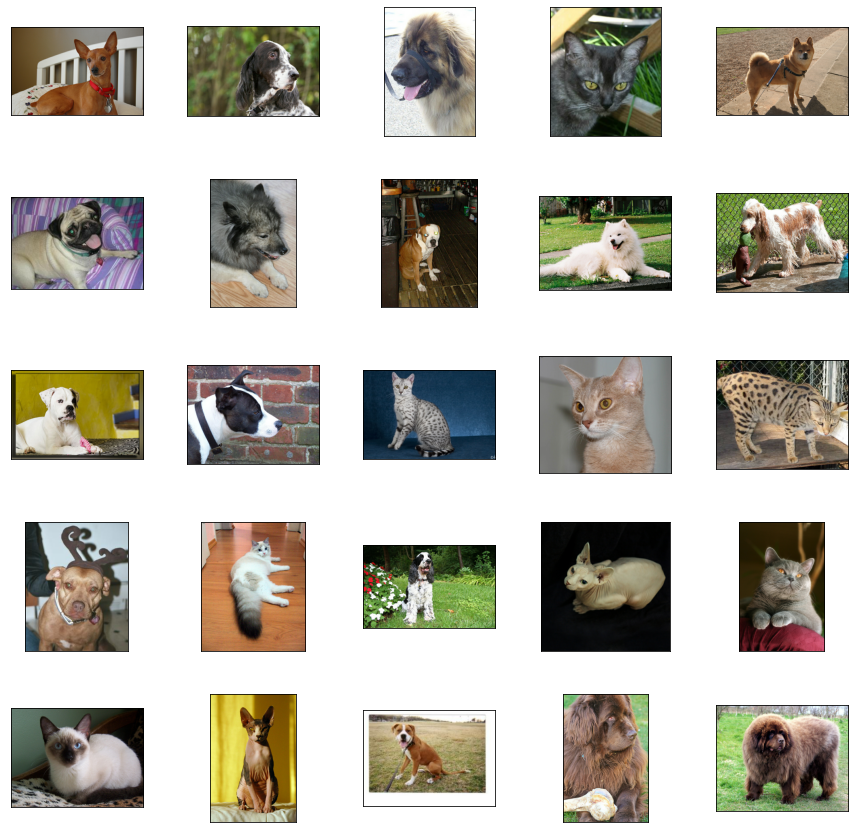

In [ ]:
fig = tfds.show_examples(pet_train, pet_info, rows = 5, cols = 5, image_key = 'image')

*   **Class 1 : Pixel belonging to the pet.**
*   **Class 2 : Pixel bordering the pet.**
*   **Class 3 : None of the above/ Surrounding pixel.**

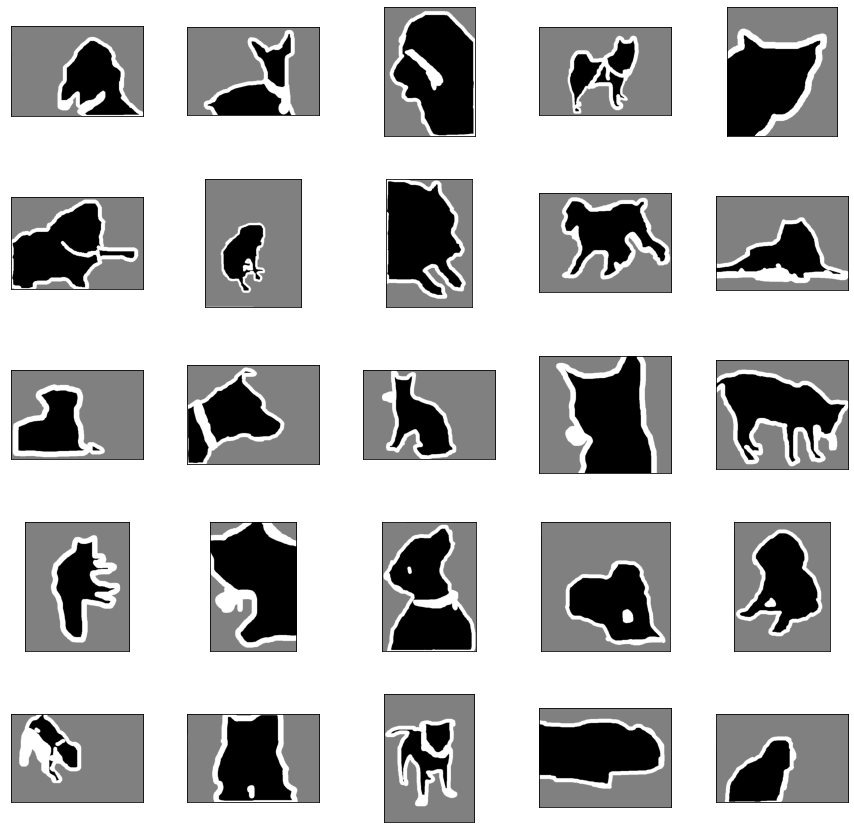

In [ ]:
fig = tfds.show_examples(pet_train, pet_info, rows = 5, cols = 5, image_key = 'segmentation_mask')

In [ ]:
fig = tfds.show_examples(ds, ds_info)


NameError: ignored

In [ ]:
pet_df = tfds.as_dataframe(pet_train, pet_info)
pet_df.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 3680 entries, 0 to 3679
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          3680 non-null   object
 1   image              3680 non-null   object
 2   label              3680 non-null   int64 
 3   segmentation_mask  3680 non-null   object
 4   species            3680 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 143.9+ KB


In [ ]:
_LABEL_CLASSES = [
    "Abyssinian", "american_bulldog", "american_pit_bull_terrier",
    "basset_hound", "beagle", "Bengal", "Birman", "Bombay", "boxer",
    "British_Shorthair", "chihuahua", "Egyptian_Mau", "english_cocker_spaniel",
    "english_setter", "german_shorthaired", "great_pyrenees", "havanese",
    "japanese_chin", "keeshond", "leonberger", "Maine_Coon",
    "miniature_pinscher", "newfoundland", "Persian", "pomeranian", "pug",
    "Ragdoll", "Russian_Blue", "saint_bernard", "samoyed", "scottish_terrier",
    "shiba_inu", "Siamese", "Sphynx", "staffordshire_bull_terrier",
    "wheaten_terrier", "yorkshire_terrier"
]
_SPECIES_CLASSES = ["Cat", "Dog"]

In [ ]:
label_name = []
for value in pet_df['label']:
  label_name.append(_LABEL_CLASSES[value])

In [ ]:
pet_df.shape

(3680, 5)

In [ ]:
pet_df['label_name']=label_name

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pet_df.head()

,file_name,image,label,segmentation_mask,species,label_name
0,b'miniature_pinscher_102.jpg',"[[[83, 59, 25], [84, 59, 28], [83, 58, 28], [8...",21,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,miniature_pinscher
1,b'english_setter_176.jpg',"[[[107, 117, 83], [101, 111, 77], [104, 109, 7...",13,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,english_setter
2,b'leonberger_153.jpg',"[[[255, 255, 255], [255, 255, 255], [255, 255,...",19,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,leonberger
3,b'shiba_inu_143.jpg',"[[[134, 156, 84], [127, 150, 70], [137, 159, 7...",31,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,shiba_inu
4,b'Bombay_186.jpg',"[[[246, 231, 200], [244, 229, 198], [239, 226,...",7,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",0,Bombay


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f679f622be0>,
      dtype=object)

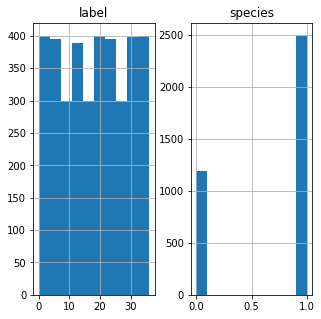

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pet_df.hist(figsize=(5,5))

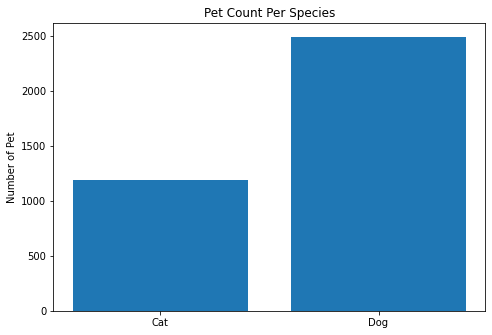

In [ ]:
fig = plt.figure()
count=pet_df['species'].value_counts()
ax = fig.add_axes([0,0,1,1])
ax.set(xticklabels = ["Cat", "Dog"])
outcome_ = ['Cat', 'Dog']
count_bar = [count[0],count[1]]
ax.bar(outcome_,count_bar)
plt.ylabel('Number of Pet')
plt.title('Pet Count Per Species')
plt.show()


In [ ]:
import plotly.express as px
fig = px.histogram(pet_df, x="label_name",color='label_name')
fig.update_layout(
    title_text='No. of pets in each category', # title of plot
    xaxis_title_text='Label name', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.update_xaxes(tickangle=310)
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(showlegend=False)
fig.show()

In [ ]:
pet_df_test = tfds.as_dataframe(pet_test, pet_info)
pet_df_test.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 3669 entries, 0 to 3668
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          3669 non-null   object
 1   image              3669 non-null   object
 2   label              3669 non-null   int64 
 3   segmentation_mask  3669 non-null   object
 4   species            3669 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 143.4+ KB


In [ ]:
label_name = []
for value in pet_df_test['label']:
  label_name.append(_LABEL_CLASSES[value])

In [ ]:
pet_df_test['label_name']=label_name

In [ ]:
pet_df_test.head()

,file_name,image,label,segmentation_mask,species,label_name
0,b'Maine_Coon_231.jpg',"[[[4, 6, 3], [4, 6, 3], [4, 6, 3], [3, 5, 2], ...",20,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",0,Maine_Coon
1,b'leonberger_73.jpg',"[[[250, 241, 232], [255, 247, 238], [251, 244,...",19,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,leonberger
2,b'saint_bernard_75.jpg',"[[[100, 120, 33], [103, 123, 38], [96, 115, 34...",28,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,saint_bernard
3,b'saint_bernard_52.jpg',"[[[182, 145, 126], [179, 143, 117], [177, 145,...",28,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,saint_bernard
4,b'beagle_98.jpg',"[[[184, 188, 199], [178, 185, 195], [180, 186,...",4,"[[[2], [2], [2], [2], [2], [2], [2], [2], [2],...",1,beagle


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67bc432f60>,
      dtype=object)

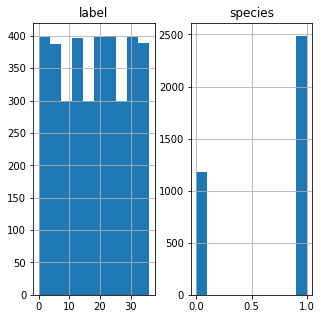

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pet_df_test.hist(figsize=(5,5))

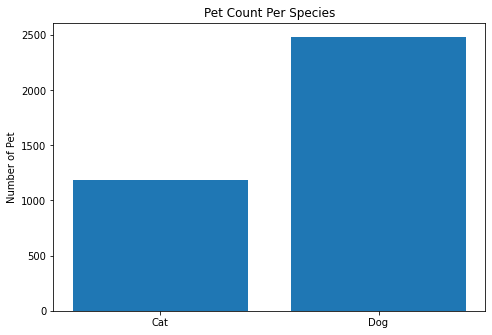

In [ ]:
fig = plt.figure()
count=pet_df_test['species'].value_counts()
ax = fig.add_axes([0,0,1,1])
ax.set(xticklabels = ["Cat", "Dog"])
outcome_ = ['Cat', 'Dog']
count_bar = [count[0],count[1]]
ax.bar(outcome_,count_bar)
plt.ylabel('Number of Pet')
plt.title('Pet Count Per Species')
plt.show()

In [ ]:
import plotly.express as px
fig = px.histogram(pet_df_test, x="label_name",color='label_name')
fig.update_layout(
    title_text='No. of pets in each category', # title of plot
    xaxis_title_text='Label name', # xaxis label
    yaxis_title_text='Counts', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.update_xaxes(tickangle=310)
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.update_traces(showlegend=False)
fig.show()

### Drone Images Dataset

In [ ]:
img_dir = '/content/dataset/semantic_drone_dataset/original_images/'

img_df = pd.DataFrame(columns=['file', 'img', 'img_mask', 'rgb_mask'])

# load image data into a dataframe
k=0
for filename in os.listdir(img_dir):
    img_df.loc[k, 'file'] = filename
    img_df.loc[k, 'img'] = resize(io.imread(img_dir + filename), (600, 400, 3), anti_aliasing=True)
    k=k+1

In [ ]:
img_df.head()

In [ ]:
label_dir = '/content/dataset/semantic_drone_dataset/label_images_semantic/'

k=0
for filename in os.listdir(label_dir):
    img_df.loc[k, 'img_mask'] = resize(io.imread(label_dir + filename), (600, 400, 1), anti_aliasing=True)
    k=k+1

In [ ]:
img_df.head()

In [ ]:
label_dir = '/content/RGB_color_image_masks/RGB_color_image_masks/'

k=0
for filename in os.listdir(label_dir):
    img_df.loc[k, 'rgb_mask'] = resize(io.imread(label_dir + filename), (600, 400, 3), anti_aliasing=True)
    k=k+1

In [ ]:
img_df.head()

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'RGB Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
display([img_df['img'][0], img_df['img_mask'][1], img_df['rgb_mask'][1]])

### Cache pet dataset

In [ ]:
def normalize(input_image, input_mask):
      input_image = tf.cast(input_image, tf.float32) / 255.0
      input_mask -= 1
      return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):

  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = pet_info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = pet_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = pet_test.map(load_image_test)

In [ ]:
pet_train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
pet_train_dataset = pet_train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
pet_test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display1(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
for image, mask in train.take(95):
  sample_image, sample_mask = image, mask
display1([sample_image, sample_mask])